***The problem is to predict annual water usage. The dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data. The values are in the units of liters per capita per day, and there are 79 observations.***

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
df = pd.read_csv('../input/deep_Learning_for_time_series_forecasting_datasets/yearly-water-usage.csv', header=0, index_col=0, parse_dates=True)
split_point = len(df) - 10
dataset, validation = df[0:split_point], df[split_point:]
print(f'{len(dataset),len(validation)}')
dataset.to_csv('../output/waterusage/dataset.csv')
validation.to_csv('../output/waterusage/validation.csv')

(69, 10)


***dataset.csv:*** Observations from 1885 to 1953 (69 observations).


***validation.csv:*** Observations from 1954 to 1963 (10 observations).

***Persistence***

First step is to evaluate a baseline performance(RMSE) value upon which the models can be build upon

In [5]:
X = dataset.values
X.astype('float32')
train_size = int(len(X) * 0.5)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print(f'Predicted: {yhat}, Expected:{obs}')
rmse = sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')


Predicted: [503], Expected:[503]
Predicted: [503], Expected:[503]
Predicted: [503], Expected:[515]
Predicted: [515], Expected:[522]
Predicted: [522], Expected:[492]
Predicted: [492], Expected:[503]
Predicted: [503], Expected:[503]
Predicted: [503], Expected:[450]
Predicted: [450], Expected:[432]
Predicted: [432], Expected:[432]
Predicted: [432], Expected:[458]
Predicted: [458], Expected:[462]
Predicted: [462], Expected:[503]
Predicted: [503], Expected:[488]
Predicted: [488], Expected:[466]
Predicted: [466], Expected:[492]
Predicted: [492], Expected:[503]
Predicted: [503], Expected:[515]
Predicted: [515], Expected:[500]
Predicted: [500], Expected:[522]
Predicted: [522], Expected:[575]
Predicted: [575], Expected:[583]
Predicted: [583], Expected:[587]
Predicted: [587], Expected:[628]
Predicted: [628], Expected:[640]
Predicted: [640], Expected:[609]
Predicted: [609], Expected:[606]
Predicted: [606], Expected:[632]
Predicted: [632], Expected:[617]
Predicted: [617], Expected:[613]
Predicted:

Next step is to run summary statistics and plots of the time series data

In [6]:
dataset.describe()

,Water
count,69.000000
mean,500.478261
std,73.901685
min,344.000000
25%,458.000000
50%,492.000000
75%,538.000000
max,662.000000


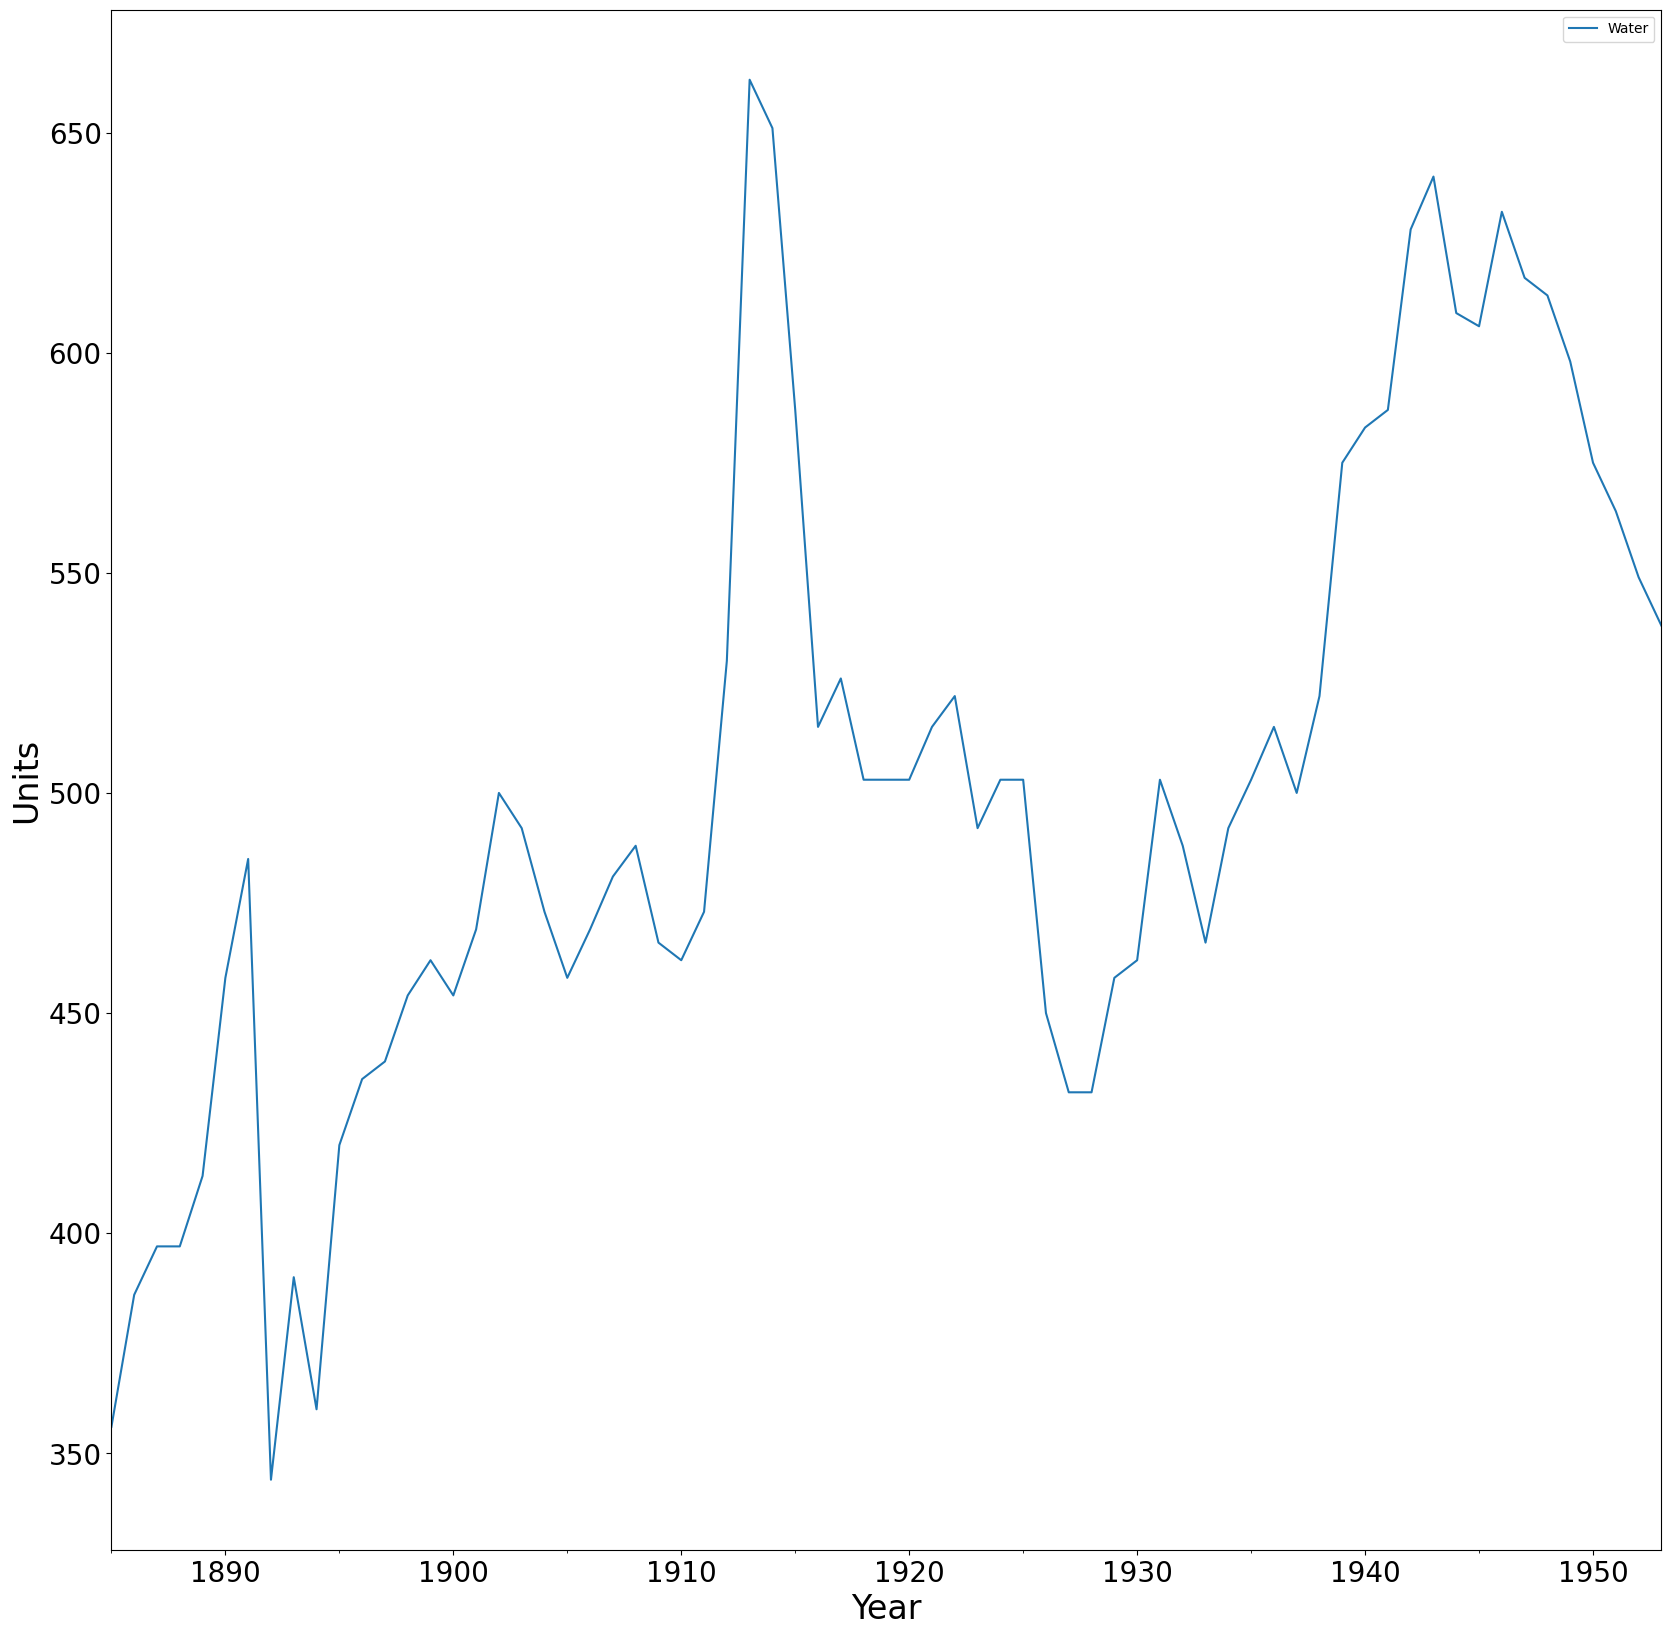

In [7]:
dataset.plot(figsize=(20,20), fontsize=20)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Units', fontsize=24)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

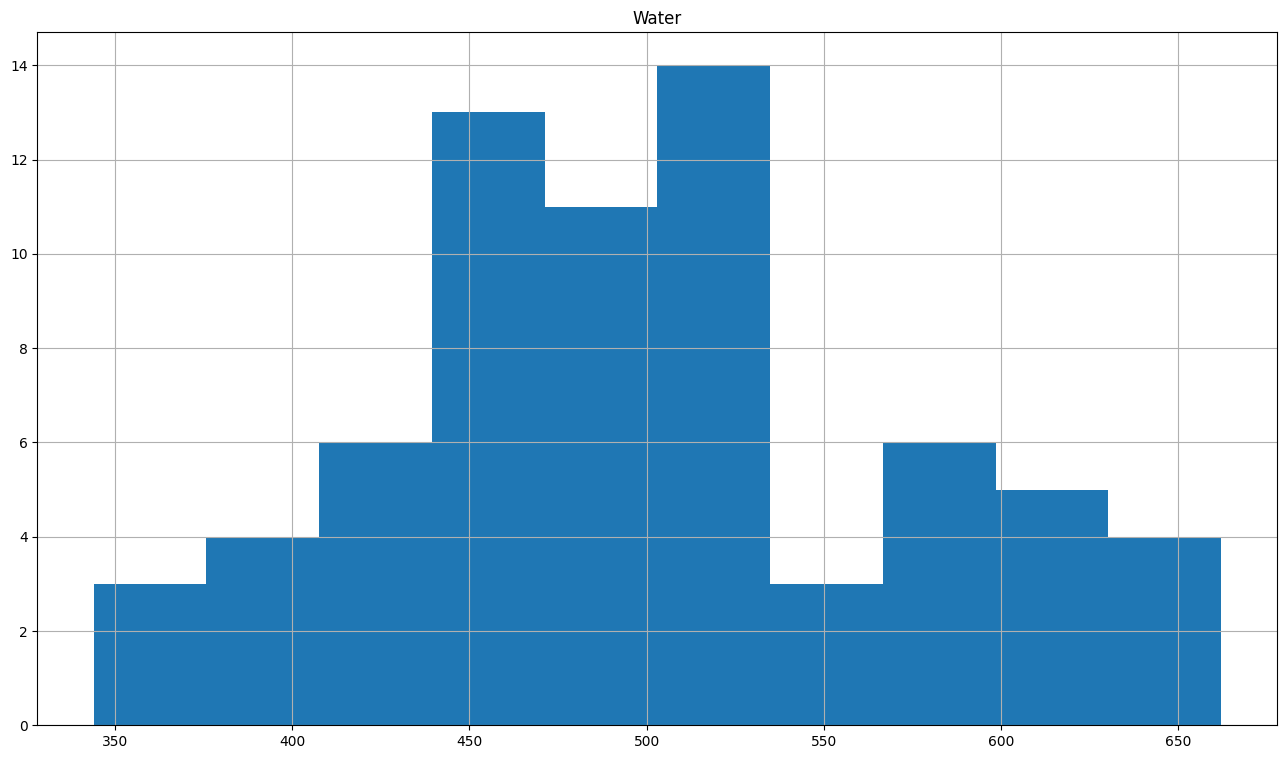

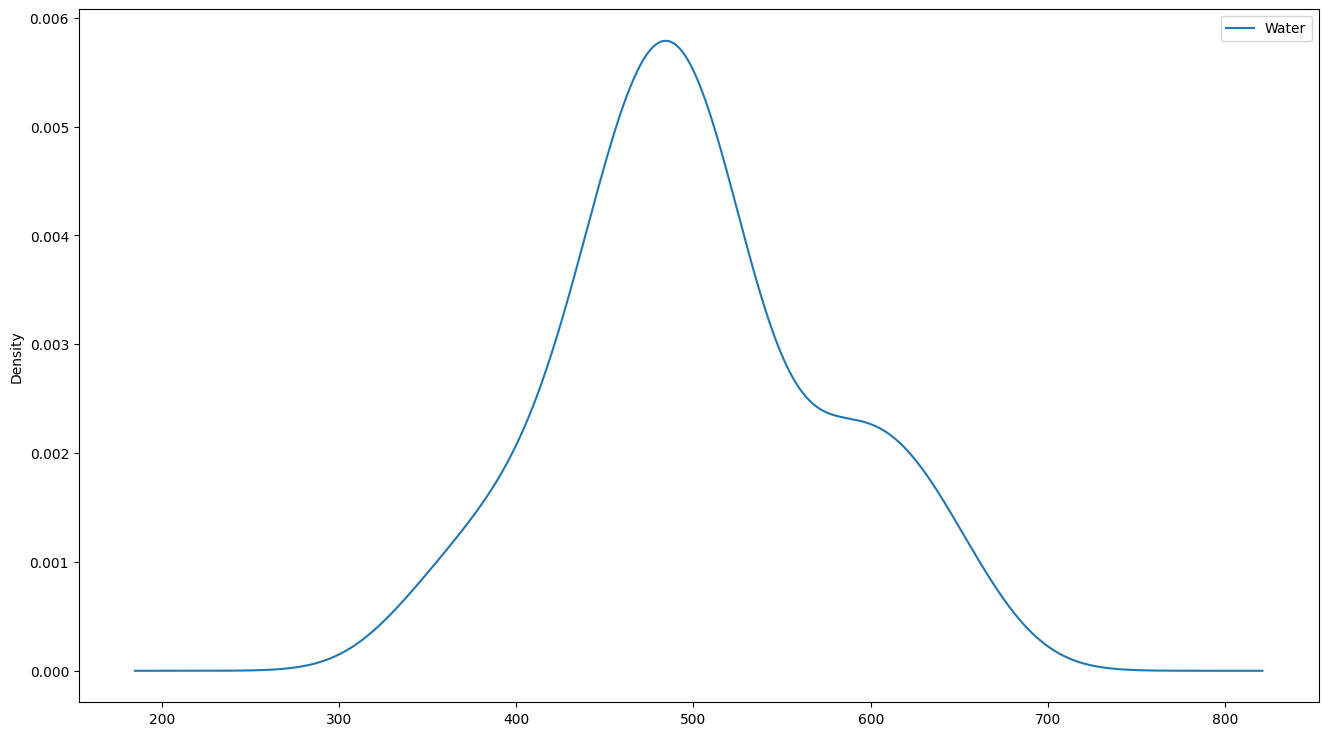

In [8]:
dataset.hist(figsize=(16,9))
dataset.plot(kind='kde', figsize=(16,9))
plt.show

The distribution is not Gaussian, but is pretty close.

The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.

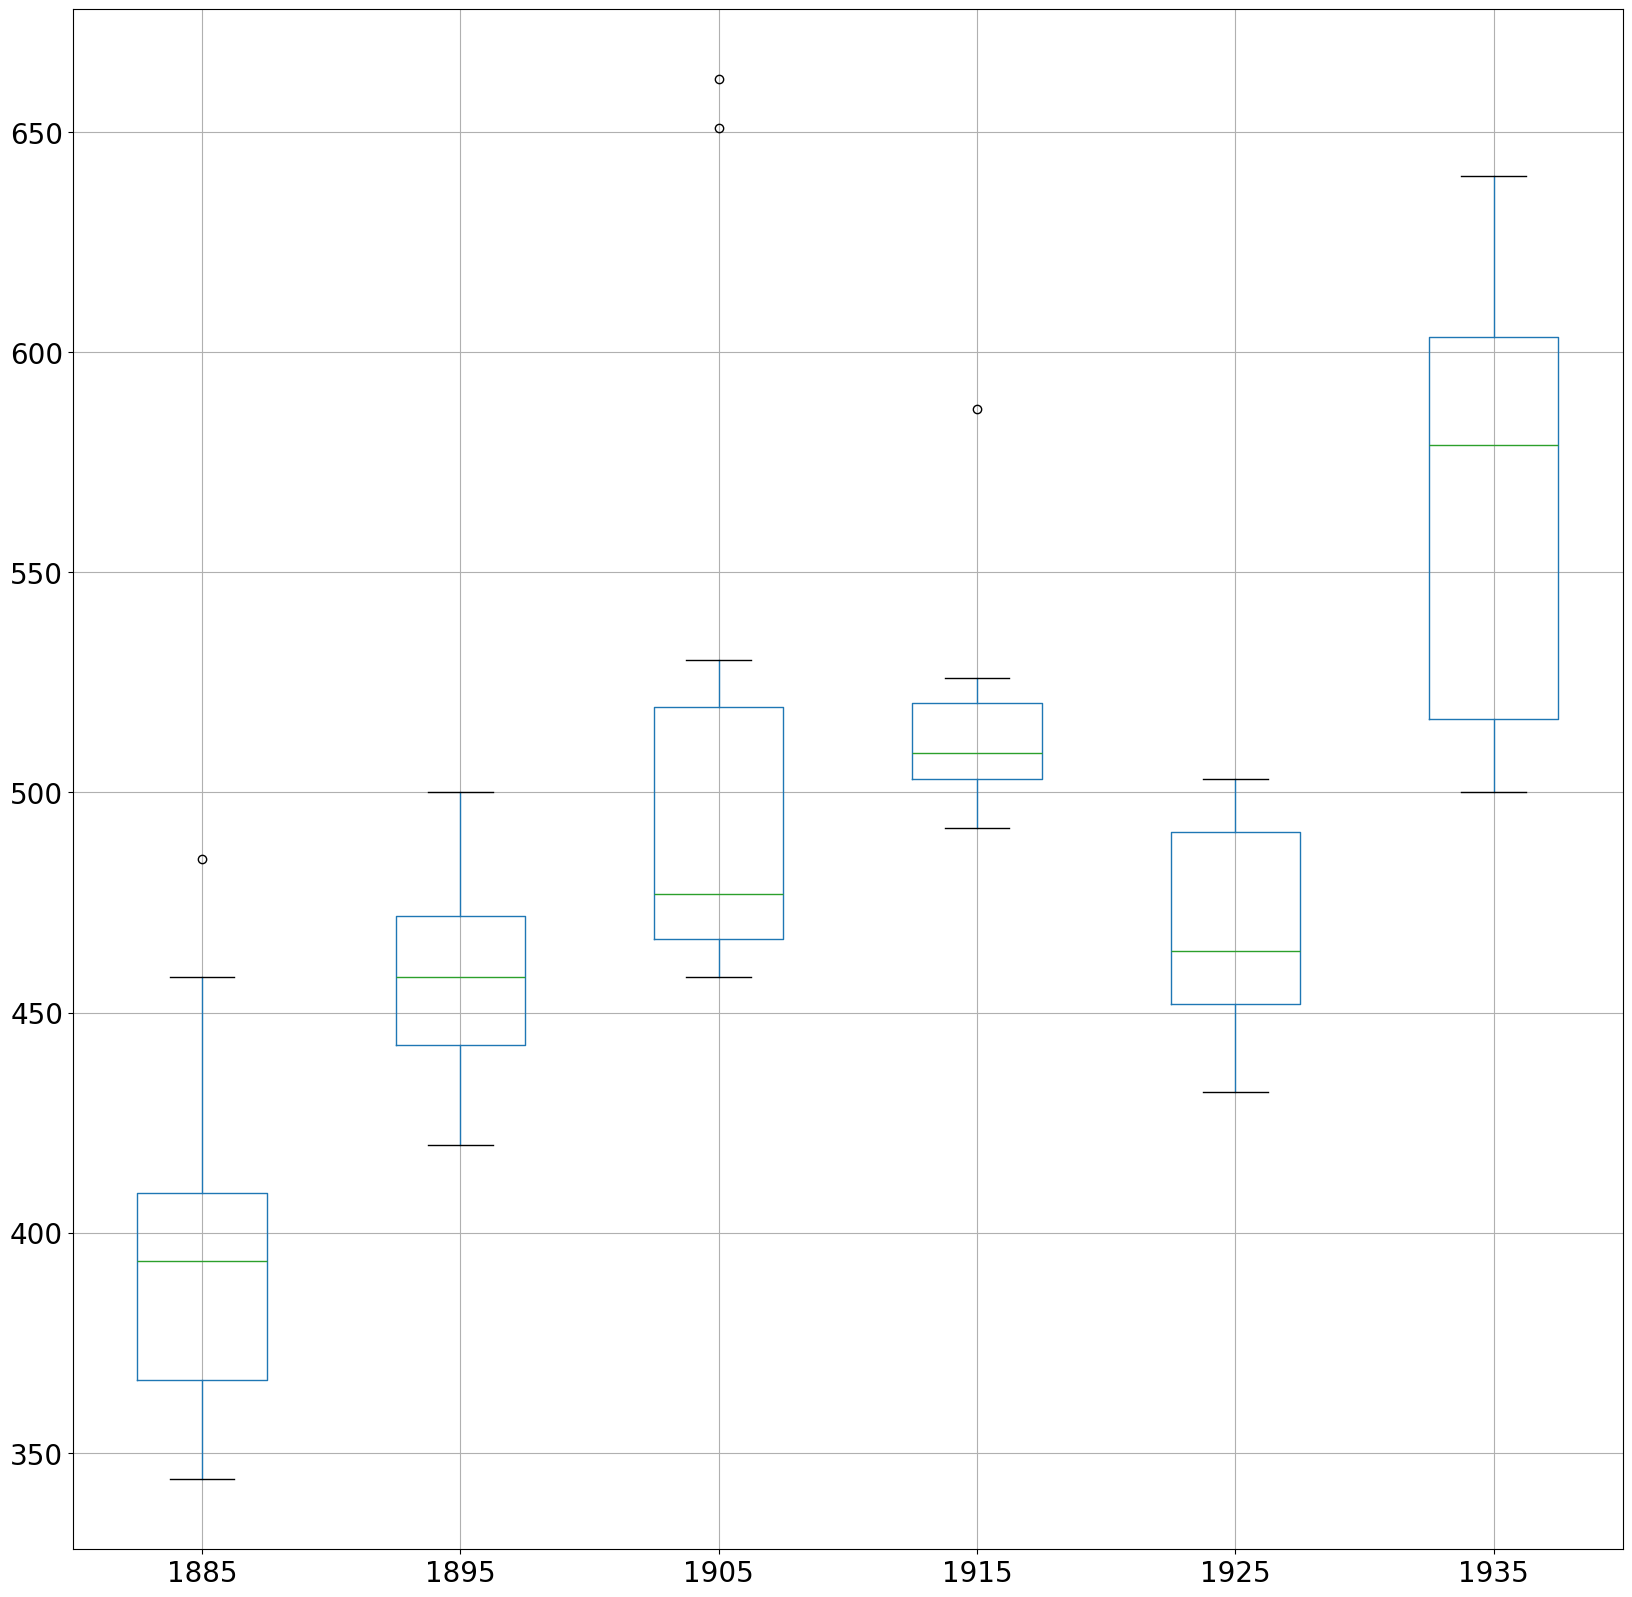

In [9]:
groups = dataset.groupby(pd.Grouper(freq='10YS'))
decades = pd.DataFrame()
for name, group in groups:
    if len(group.values) is 10:
        decades[name.year] = group.values.flatten()
decades.boxplot(figsize=(20,20), fontsize=20)
plt.show()

***utoregressive Integrated Moving Average(ARIMA) Models Building***

First manually configure algo parameters

Automatically configure(Grid Search)

Review Residual error

ARIMA has three Parameters p,d,q. 

In [10]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

ADF Statistics: -6.126718808474715
p-value: 8.593851954694127e-08
Critical Values: 
1%, -3.5335601309235605
5%, -2.9064436883991434
10%, -2.590723948576676


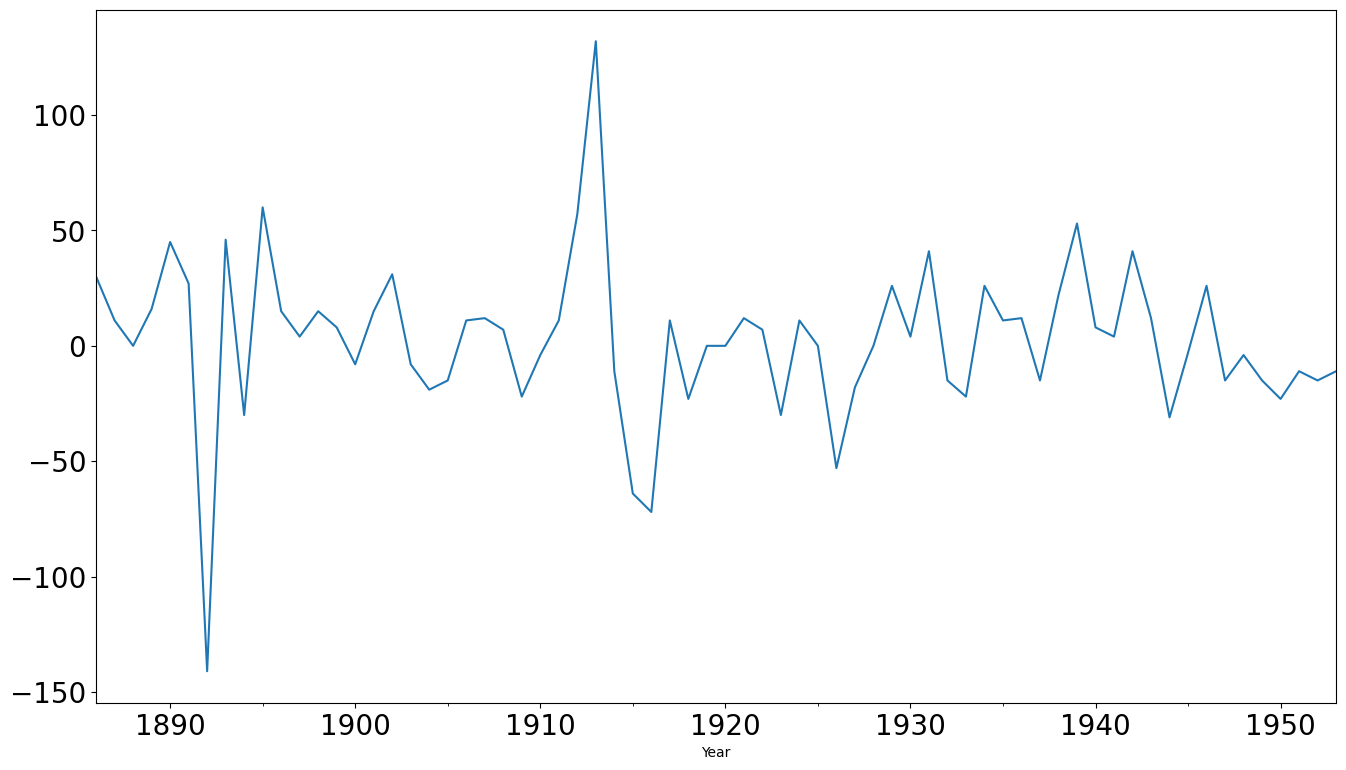

In [11]:
X = dataset.values.astype('float32')
stationary = difference(X)
stationary.index = dataset.index[1:]
#check if stationary
result = adfuller(stationary)
print(f'ADF Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: ')
for key, value in result[4].items():
    print(f'{key}, {value}') 
stationary.to_csv('../output/waterusage/stationary.csv') 
for i in range(len(stationary)):
    stationary.iloc[i] = int(stationary.iloc[i])
stationary.plot(figsize =(16,9), fontsize=20)
plt.show()

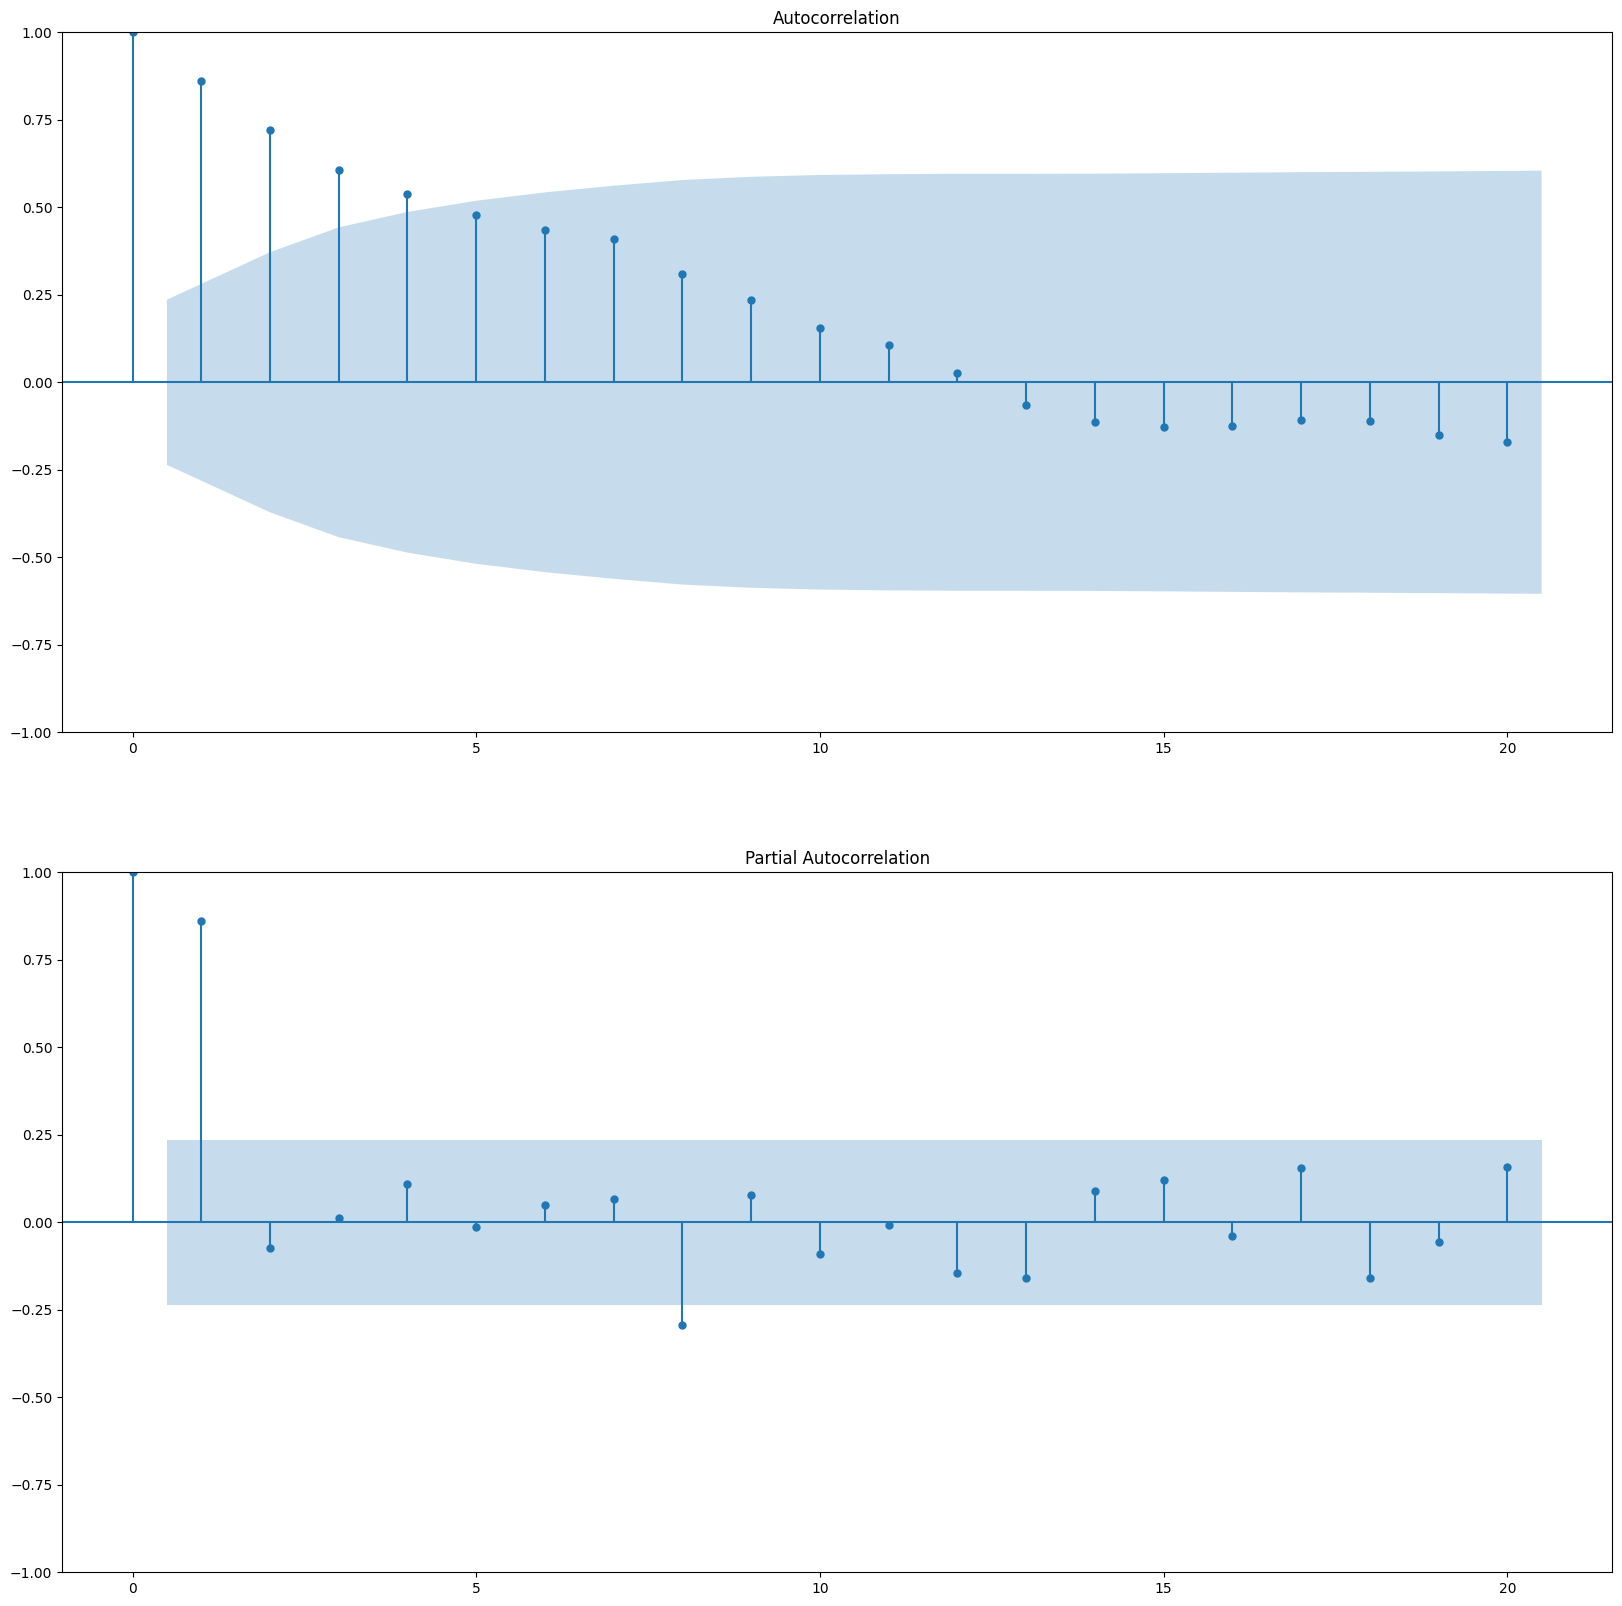

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plot_acf(dataset, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(dataset, lags=20, ax=plt.gca())
plt.show()

From what I understand AR lags can be found in ACF plot. if you see it properly the there are 4 lines outside the confidence interval. Same goes for the PACF function which shows lags to 1 time step.

So a good starting point of the parameters of ARIMA p and q is 4 and 1 respectively

In [13]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print(f'Predicted:{yhat}, Expected:{obs}')
rmse = sqrt(mean_squared_error(test,predictions))
print(f'RMSE: {rmse}')

Predicted:530.1008630672023, Expected:[503]
Predicted:511.15440273014207, Expected:[503]
Predicted:515.6373423036813, Expected:[515]
Predicted:520.9038062720218, Expected:[522]
Predicted:525.0086754531121, Expected:[492]
Predicted:492.3595362340107, Expected:[503]
Predicted:504.6637502588682, Expected:[503]
Predicted:512.0823763526411, Expected:[450]
Predicted:454.31247747795453, Expected:[432]
Predicted:441.32888578672043, Expected:[432]
Predicted:452.41835882027175, Expected:[458]
Predicted:470.22343720653583, Expected:[462]
Predicted:465.8599749052128, Expected:[503]
Predicted:498.1116413668368, Expected:[488]
Predicted:483.3994276092023, Expected:[466]
Predicted:455.1279850995236, Expected:[492]
Predicted:492.31990186262516, Expected:[503]
Predicted:503.71075636383165, Expected:[515]
Predicted:505.815172239405, Expected:[500]
Predicted:493.16503016239085, Expected:[522]
Predicted:515.4815723668228, Expected:[575]
Predicted:571.3324877615055, Expected:[583]
Predicted:568.10170516475

***GRID Search ARIMA Hyperparameters***

p - 0 to 4

d - 0 to 2

q - 0 to 4

In [14]:
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X)*0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #predict
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [15]:
#grid search function
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print(f'ARIMA:{order}, RMSE:{rmse}')
                except:
                    continue
    print(f'Best ARIMA Model:{best_cfg}, RMSE:{best_score}')

In [ ]:

# Evaluate Models
p_values = range(0,5)
d_values = range(0,3)
q_values = range(0,5)
evaluate_models(dataset.values, p_values, d_values, q_values)

ARIMA:(0, 0, 0), RMSE:76.75487535493315
ARIMA:(0, 0, 1), RMSE:47.3474689520166
ARIMA:(0, 0, 2), RMSE:36.03010583560391
ARIMA:(0, 0, 3), RMSE:32.5365075662711
ARIMA:(0, 0, 4), RMSE:30.768228390834416
ARIMA:(0, 1, 0), RMSE:21.97466073198206
ARIMA:(0, 1, 1), RMSE:21.906762382018922
ARIMA:(0, 1, 2), RMSE:22.177657084890928
ARIMA:(0, 1, 3), RMSE:24.730519416613724
ARIMA:(0, 1, 4), RMSE:24.84390603184348
ARIMA:(0, 2, 0), RMSE:28.99162440627086
ARIMA:(0, 2, 1), RMSE:22.313732925719073
ARIMA:(0, 2, 2), RMSE:22.19647060655736
ARIMA:(0, 2, 3), RMSE:22.35579608492649
ARIMA:(0, 2, 4), RMSE:28.511820169998867
ARIMA:(1, 0, 0), RMSE:23.95651309725368
ARIMA:(1, 0, 1), RMSE:23.991321816882554
ARIMA:(1, 0, 2), RMSE:25.384233300655136
ARIMA:(1, 0, 3), RMSE:25.05890214048652
ARIMA:(1, 0, 4), RMSE:25.109445279711544
ARIMA:(1, 1, 0), RMSE:21.92123014783417
ARIMA:(1, 1, 1), RMSE:21.87948851052933
ARIMA:(1, 1, 2), RMSE:23.314190038659305
ARIMA:(1, 1, 3), RMSE:24.815985912550868
ARIMA:(1, 1, 4), RMSE:27.23921550688432
ARIMA:(1, 2, 0), RMSE:27.463627226371464
ARIMA:(1, 2, 1), RMSE:22.219080839265455
ARIMA:(1, 2, 2), RMSE:22.78639706056205
ARIMA:(1, 2, 3), RMSE:22.923392349199737
ARIMA:(1, 2, 4), RMSE:28.475598358930085
ARIMA:(2, 0, 0), RMSE:24.101322898105167
ARIMA:(2, 0, 1), RMSE:24.112607294195826
ARIMA:(2, 0, 2), RMSE:25.451060996514805
ARIMA:(2, 0, 3), RMSE:25.117905113364273
ARIMA:(2, 0, 4), RMSE:25.242485782165755
ARIMA:(2, 1, 0), RMSE:21.732242688897454
ARIMA:(2, 1, 1), RMSE:23.822559467876687
ARIMA:(2, 1, 2), RMSE:27.510362827304945
ARIMA:(2, 1, 3), RMSE:26.36386860285807
ARIMA:(2, 1, 4), RMSE:26.50941893408038
ARIMA:(2, 2, 0), RMSE:25.28228479244516
ARIMA:(2, 2, 1), RMSE:22.064175109664465
ARIMA:(2, 2, 2), RMSE:23.25266567458251
ARIMA:(2, 2, 3), RMSE:22.675046290635166
ARIMA:(2, 2, 4), RMSE:25.448718247512907
ARIMA:(3, 0, 0), RMSE:24.166513427208848
ARIMA:(3, 0, 1), RMSE:24.660579317101508
ARIMA:(3, 0, 2), RMSE:24.285312647792498
ARIMA:(3, 0, 3), RMSE:26.414155696488148
ARIMA:(3, 0, 4), RMSE:26.556050335508655
ARIMA:(3, 1, 0), RMSE:24.269221128380778
ARIMA:(3, 1, 1), RMSE:25.48598065845193
ARIMA:(3, 1, 2), RMSE:25.393431299395015
ARIMA:(3, 1, 3), RMSE:24.10654694027871
ARIMA:(3, 1, 4), RMSE:26.60674906083468
ARIMA:(3, 2, 0), RMSE:25.626682574154874
ARIMA:(3, 2, 1), RMSE:24.827306149484908
ARIMA:(3, 2, 2), RMSE:30.084057144113906
ARIMA:(3, 2, 3), RMSE:24.760046974306583
ARIMA:(3, 2, 4), RMSE:24.939313722229876
ARIMA:(4, 0, 0), RMSE:25.112701528058352
ARIMA:(4, 0, 1), RMSE:25.22846370855782
ARIMA:(4, 0, 2), RMSE:25.784302275949727
ARIMA:(4, 0, 3), RMSE:26.352776912011453
ARIMA:(4, 0, 4), RMSE:27.369896327513707
ARIMA:(4, 1, 0), RMSE:24.79939870378438
ARIMA:(4, 1, 1), RMSE:25.261593225718077
ARIMA:(4, 1, 2), RMSE:25.25721086950287
ARIMA:(4, 1, 3), RMSE:25.38035420029827
ARIMA:(4, 1, 4), RMSE:26.890764558134602
ARIMA:(4, 2, 0), RMSE:27.092514366317904
ARIMA:(4, 2, 1), RMSE:25.675788348784486
ARIMA:(4, 2, 2), RMSE:25.355421537254347
ARIMA:(4, 2, 3), RMSE:29.441949561024384
ARIMA:(4, 2, 4), RMSE:32.61349539414274


***Best ARIMA Model:(2, 1, 0), RMSE:21.732242688897454***


In [16]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
residuals.describe()

,0
count,35.000000
mean,1.081458
std,22.022201
min,-52.104849
25%,-16.209637
50%,-0.454858
75%,12.089062
max,51.281127


<Figure size 1600x900 with 0 Axes>

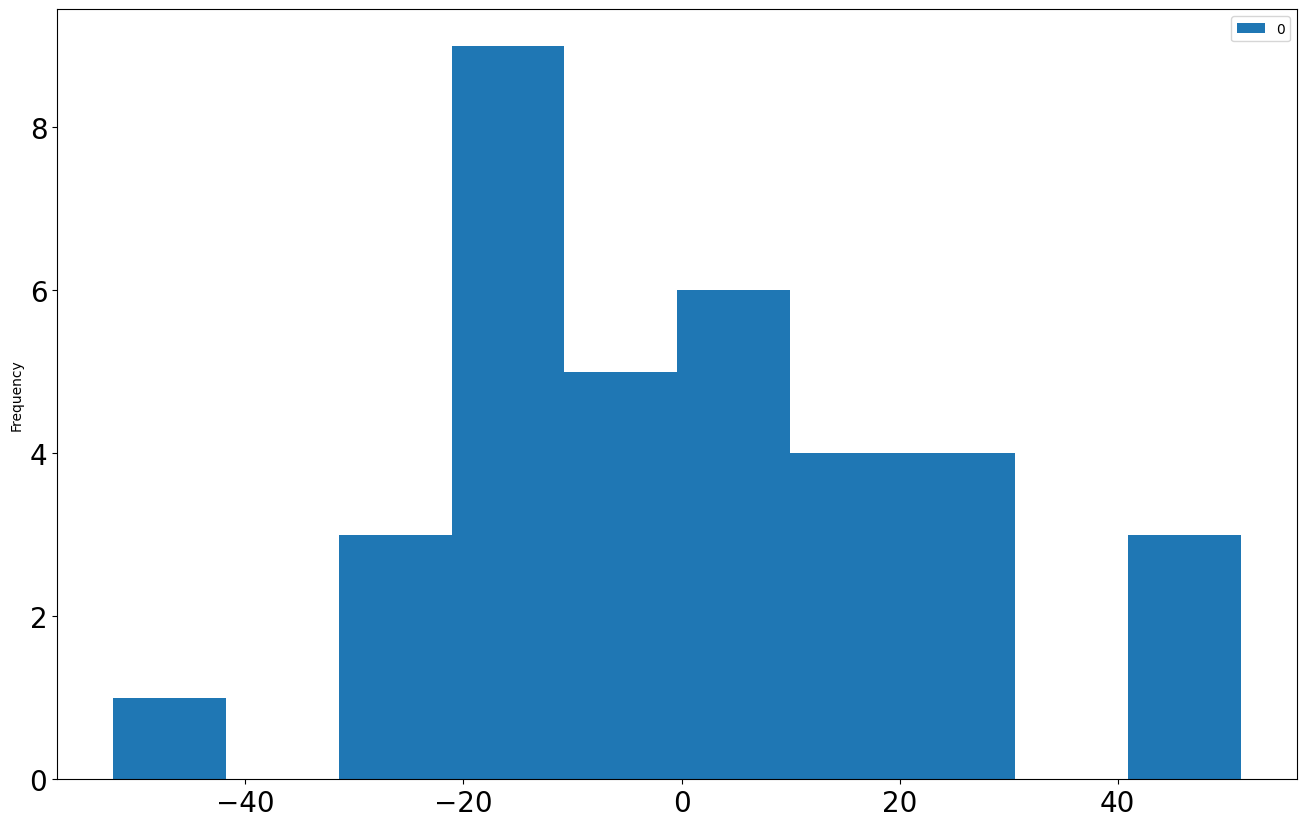

In [17]:
plt.figure(figsize=(16,9))
residuals.plot(kind='hist', figsize=(16,10), fontsize=20)
plt.show()

<Figure size 640x480 with 0 Axes>

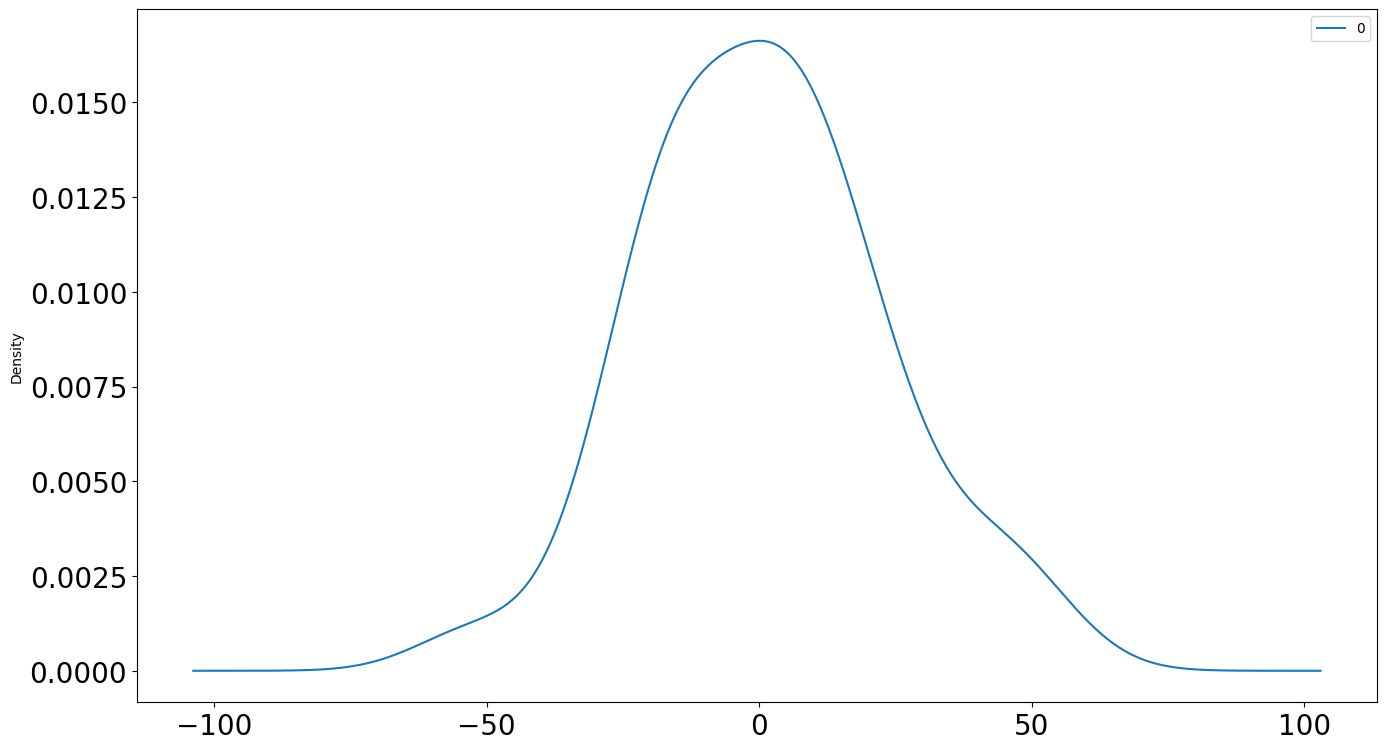

In [18]:
plt.figure()
residuals.plot(kind='kde',figsize=(16,9), fontsize=20)
plt.show()

In [19]:
residuals.describe()[0][1]

1.081457731785812

RMSE: 21.70531781530732
                  0
count  3.500000e+01
mean   8.120488e-15
std    2.202220e+01
min   -5.318631e+01
25%   -1.729110e+01
50%   -1.536316e+00
75%    1.100760e+01
max    5.019967e+01


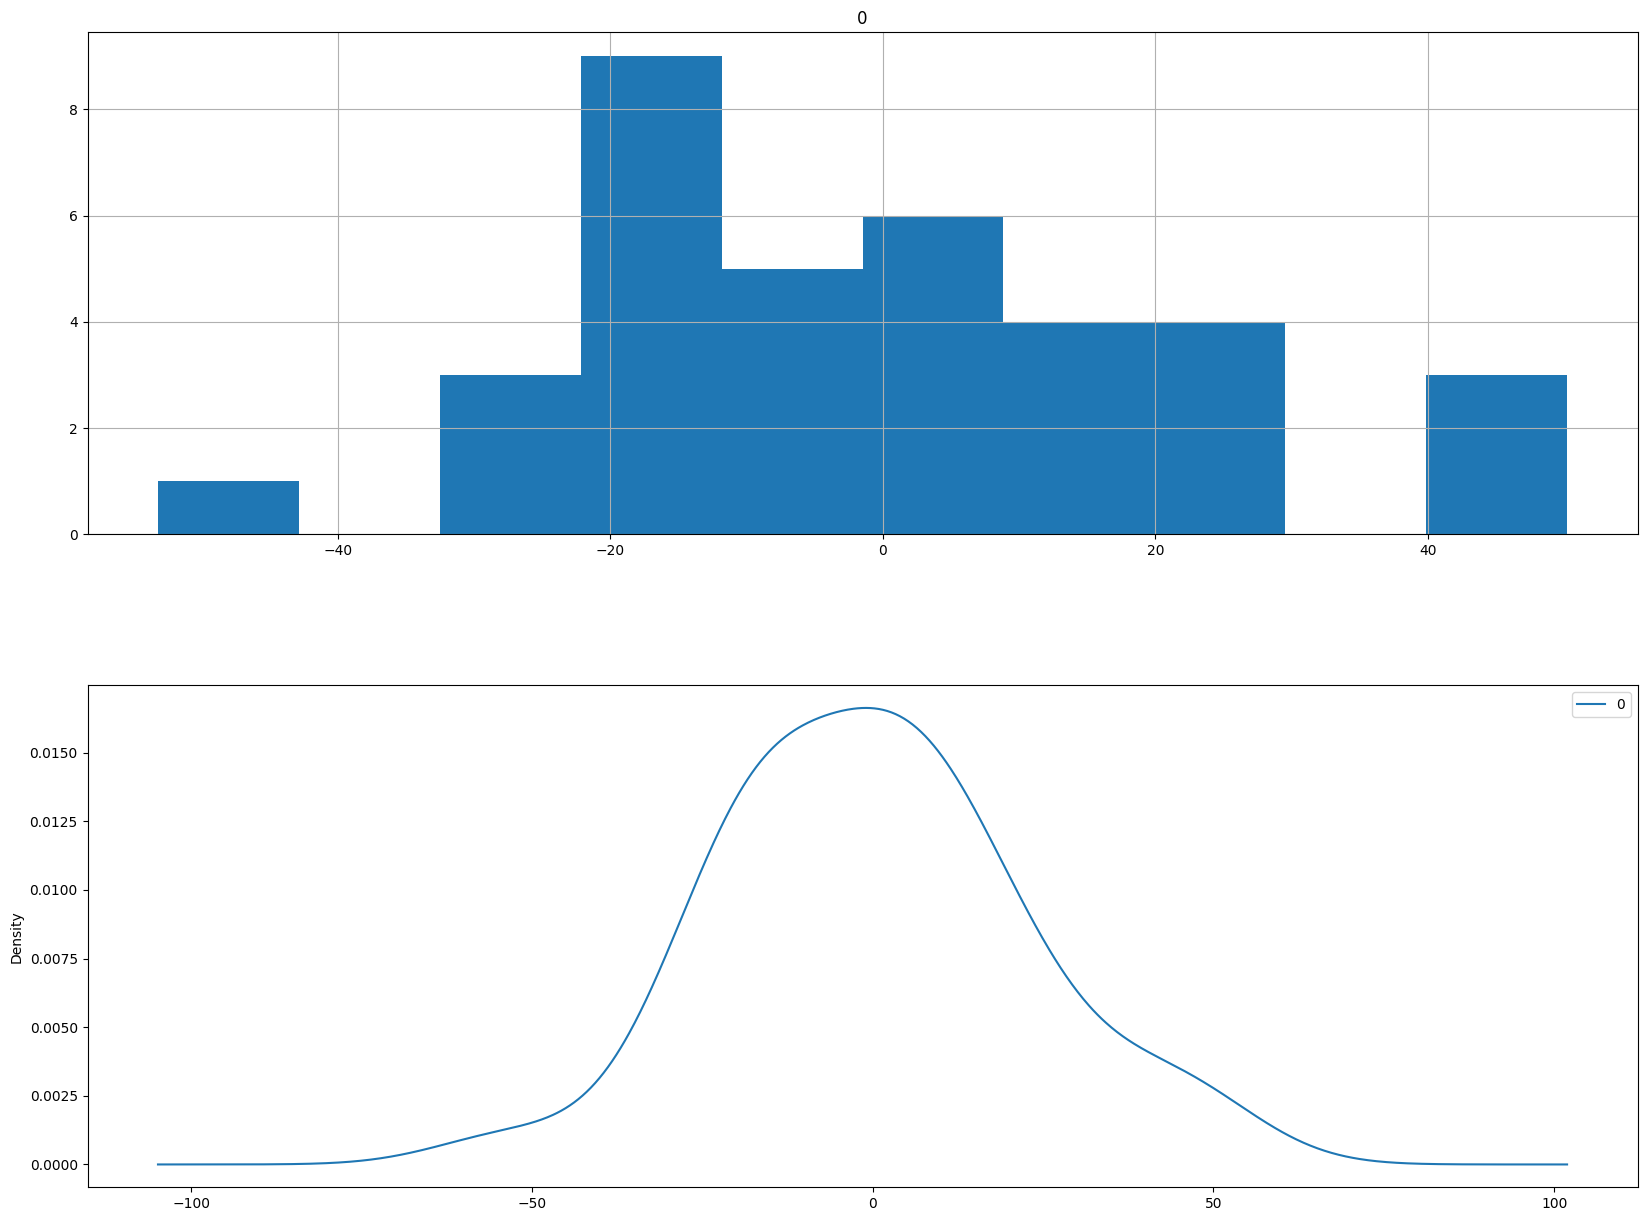

In [20]:
history = [x for x in train]
predictions = list()
bias = residuals.describe()[0][1]
for i in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0] + bias
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca(), figsize=(20,15))
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca(), figsize=(20,15))
plt.show()

***FINALIZE MODEL***

In [21]:
X = dataset.values
X = X.astype('float32')

model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()

bias = 1.081624

model_fit.save('../output/waterusage/model.pkl')
np.save('../output/waterusage/model_bias.npy', [bias])

In [22]:
model_fit = ARIMAResults.load('../output/waterusage/model.pkl')
bias = np.load('../output/waterusage/model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print(f'Predicted:{yhat}')

Predicted:[540.01079828]


Predicted:[540.01079828], Expected:[568.]
Predicted:[571.59289191], Expected:[575.]
Predicted:[573.29169976], Expected:[579.]
Predicted:[579.5615522], Expected:[587.]
Predicted:[588.06421972], Expected:[602.]
Predicted:[603.02499713], Expected:[594.]
Predicted:[593.17746395], Expected:[587.]
Predicted:[588.5561359], Expected:[587.]
Predicted:[588.79635275], Expected:[625.]
Predicted:[627.94683712], Expected:[613.]
RMSE: 16.532604678352378


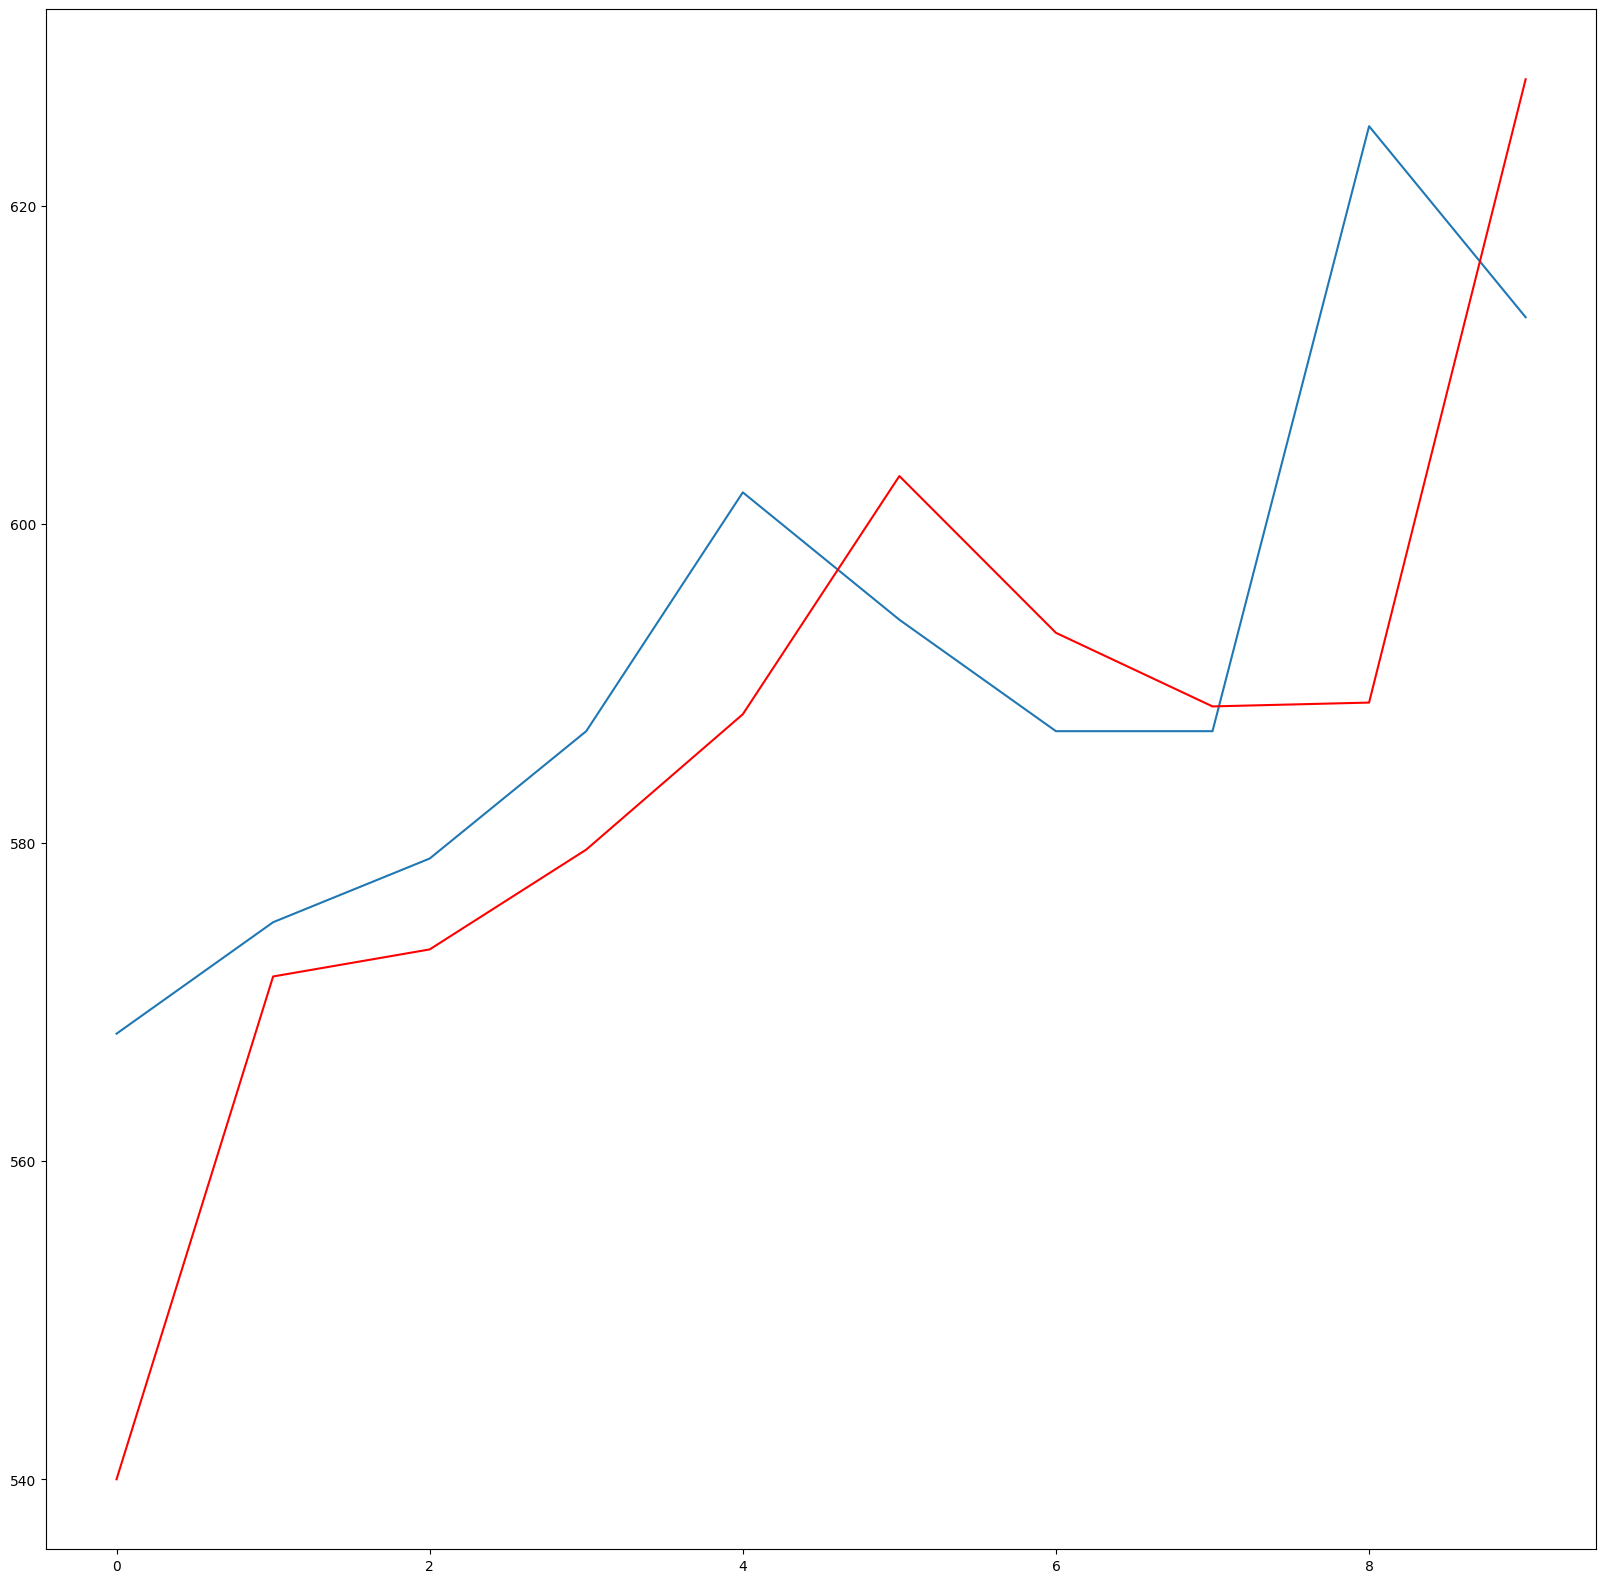

In [23]:
X = dataset.values.astype('float32')
Y = validation.values.astype('float32')

model_fit = ARIMAResults.load('../output/waterusage/model.pkl')
bias = np.load('../output/waterusage/model_bias.npy')

predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(Y[0])
print(f'Predicted:{yhat}, Expected:{Y[0]}')

for i in range(1, len(Y)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    obs = Y[i]
    history.append(obs)
    print(f'Predicted:{yhat}, Expected:{obs}')

rmse = sqrt(mean_squared_error(Y, predictions))
print(f'RMSE: {rmse}')
plt.figure(figsize=(20,20))
plt.plot(Y)
plt.plot(predictions, color = 'red')
plt.show()

Ok, Time to use boosting algorithm on this dataset. First learning

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from math import sqrt

dataset = pd.read_csv('../input/deep_Learning_for_time_series_forecasting_datasets/yearly-water-usage.csv', header= 0, index_col=0, parse_dates=True)
df = pd.DataFrame(dataset.values)
dataset = pd.concat([df.shift(1), df.astype('float32')], axis=1)
dataset.columns = ['t', 't+1']
dataset = dataset.drop([0])
validation_size = int(len(df)*0.8)
train, validation = dataset[:validation_size], dataset[validation_size:]
train.to_csv('../output/waterusage/boosting/train.csv')
validation.to_csv('../output/waterusage/boosting/validation.csv')


Best: -1295.606198979592,{'n_estimators': 300}
RMSE for Training Set: 61.31144976328091
RMSE of test data set: 47.511959508068024


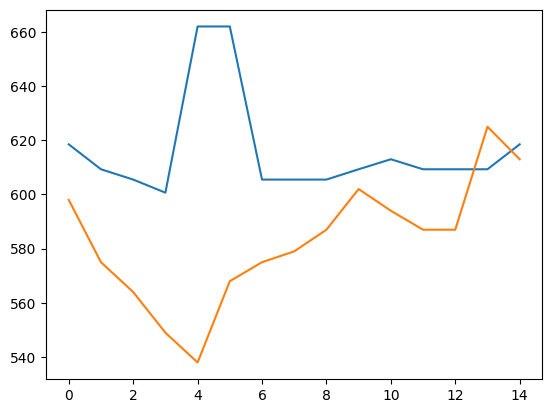

In [194]:

dataset = pd.read_csv('../output/waterusage/boosting/train.csv', header= 0, index_col=0)
array = dataset.values
X = array[1:,0:dataset.shape[1]-1]
Y = array[1:,dataset.shape[1]-1]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y, test_size=validation_size, random_state=seed)
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'
param_grid = dict(n_estimators = np.array(np.arange(50,450,50)))
base_learner = DecisionTreeRegressor(max_depth=5)
model = AdaBoostRegressor(estimator=base_learner, random_state=seed)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result=grid.fit(X_train, Y_train)
print(f'Best: {grid_result.best_score_},{grid_result.best_params_}')
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params =  grid_result.cv_results_['params']
# for mean,std,param in zip(means,stds, params):
#     print(f'{mean}({std}) with {param}')
model = AdaBoostRegressor(random_state=seed, n_estimators=list(grid_result.best_params_.values())[0])
model.fit(X_train, Y_train)
prediction = model.predict(X_validation)
print(f'RMSE for Training Set: {sqrt(mean_squared_error(Y_validation, prediction))}')
joblib.dump(model, '../output/waterusage/boosting/model_ADABoost.pkl')
validation = pd.read_csv('../output/waterusage/boosting/validation.csv', header=0, index_col=0)
X_validation, Y_validation = validation.iloc[:,0].values.reshape(-1, 1), validation.iloc[:,1].values.reshape(-1, 1)
best_model = joblib.load('../output/waterusage/boosting/model_ADABoost.pkl')
prediction = best_model.predict(X_validation)
rmse = sqrt(mean_squared_error(Y_validation, prediction))
print(f'RMSE of test data set: {rmse}')
plt.plot(prediction)
plt.plot(Y_validation)
plt.show()

Best: -1421.5685760444608,{'n_estimators': 50}
68.15389827946044
RMSE of test data set: 44.62059733377578


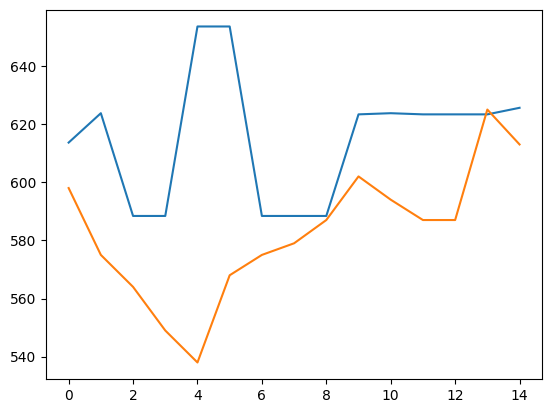

In [195]:
dataset = pd.read_csv('../output/waterusage/boosting/train.csv', header= 0, index_col=0)
array = dataset.values
X = array[1:,0:dataset.shape[1]-1]
Y = array[1:,dataset.shape[1]-1]
validation_size = 0.10
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y, test_size=validation_size, random_state=seed)
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'
param_grid = dict(n_estimators = np.array(np.arange(50,450,50)))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result=grid.fit(X_train, Y_train)
print(f'Best: {grid_result.best_score_},{grid_result.best_params_}')
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params =  grid_result.cv_results_['params']
# for mean,std,param in zip(means,stds, params):
#     print(f'{mean}({std}) with {param}')

model = GradientBoostingRegressor(random_state=seed, n_estimators=list(grid_result.best_params_.values())[0])
model.fit(X_train, Y_train)
prediction = model.predict(X_validation)
print(sqrt(mean_squared_error(Y_validation, prediction)))
joblib.dump(model, '../output/waterusage/boosting/model_GradientBoost.pkl')
validation = pd.read_csv('../output/waterusage/boosting/validation.csv', header=0, index_col=0)
X_validation, Y_validation = validation.iloc[:,0].values.reshape(-1, 1), validation.iloc[:,1].values.reshape(-1, 1)
best_model = joblib.load('../output/waterusage/boosting/model_GradientBoost.pkl')
prediction = best_model.predict(X_validation)
rmse = sqrt(mean_squared_error(Y_validation, prediction))
print(f'RMSE of test data set: {rmse}')
plt.plot(prediction)
plt.plot(Y_validation)
plt.show()

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best: -1300.1227215109102, {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
RMSE of Training Data Set: 29.881125607667318
RMSE of test data set: 16.029024159911035


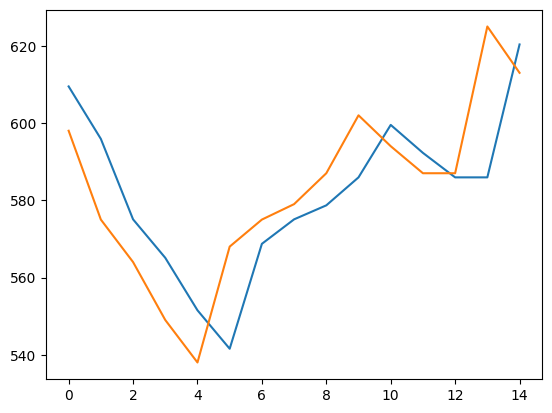

In [196]:

dataset = pd.read_csv('../output/waterusage/boosting/train.csv', header= 0, index_col=0)
array = dataset.values
X = array[1:,0:dataset.shape[1]-1]
Y = array[1:,dataset.shape[1]-1]
validation_size = 0.10
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
model = SVR()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['auto', 'scale'],
    'epsilon': [0.1, 0.2, 0.5]
}
num_folds = 10
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold, verbose = 1)
grid_result = grid.fit(X_train, Y_train)
print(f'Best: {grid_result.best_score_}, {grid_result.best_params_}')
best_model = grid_result.best_estimator_
prediction = best_model.predict(X_validation)
rmse = sqrt(mean_squared_error(Y_validation, prediction))
print(f'RMSE of Training Data Set: {rmse}')
joblib.dump(best_model, '../output/waterusage/boosting/model_SVM.pkl')
validation = pd.read_csv('../output/waterusage/boosting/validation.csv', header=0, index_col=0)
X_validation, Y_validation = validation.iloc[:,0].values.reshape(-1, 1), validation.iloc[:,1].values.reshape(-1, 1)
best_model = joblib.load('../output/waterusage/boosting/model_SVM.pkl')
prediction = best_model.predict(X_validation)
rmse = sqrt(mean_squared_error(Y_validation, prediction))
print(f'RMSE of test data set: {rmse}')
plt.plot(prediction)
plt.plot(Y_validation)
plt.show()